In [1]:
import os
from dotenv import load_dotenv
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer
import os
import requests 
import json
import time
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
from shapely.ops import unary_union

In [2]:
# Loading in the API Key
load_dotenv()
PLANET_API_KEY = os.getenv('API_KEY')

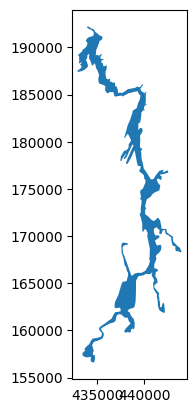

In [3]:
dir_path = '/Users/aidanhayes/Desktop/Planet-Imagery-API/Aidan_LF_AOI_StormDates'
os.chdir(dir_path)

"""
This script reads all shapefiles in a directory, and extracts the AOI polygons 
stored in the shapefile to a geopandas Polygon to query Planet Imagery downloads
through their API. The code logic assumes only one polygon is stored in each
shapefile.

Harrison Myers
6/7/2024

Dependencies: 
    -- os
    -- geopandas (pip install geopandas)
    -- shapely (pip install shapely)
"""

def transform_coordinates(easting, northing, from_epsg, to_epsg):
    """
    Transforms easting-northing coordinates to lon/lat
    
    Params:
        easting (float, req): easting location
        northing (float, req): northing location
        from_epsg (int, req): EPSG code for spatial projection easting and 
                              northing points are in
        to_epsg (int, req): EPSG code to convert to for lat/lon
        
    Returns:
        lon, lat (float): longitude and latitude of easting/northing coordinate
    """
    transformer = Transformer.from_crs(f'epsg:{from_epsg}', f'epsg:{to_epsg}', always_xy=True)
    lon, lat = transformer.transform(easting, northing)
    return lon, lat

def getPolygons(folderPath, from_epsg, to_epsg):
    """
    Reads all shapefiles in a directory and stores their respective polygons
    in a dictionary
    Params:
        -- folderPath (str, req): Path to folder where shapefiles are stored
    returns:
        -- polygons (dict): Dictionary of polygons indexed by first two letters
                            of site name
    """
    polygons = {}
    for f in os.listdir(folderPath):
        if f.endswith('.shp'): # only read shapefiles
            fpath = os.path.join(folderPath, f) # get path to shapefile
            gdf = gpd.read_file(fpath) # read shapefile
            for geom in gdf.geometry:
                if isinstance(geom, Polygon):
                    coords = geom.exterior.coords._coords[:, :2]
                    lonlat_coords = [transform_coordinates(x, y, from_epsg, to_epsg) for x, y in coords]
                    polygons[f'{f[:3]}'] = lonlat_coords

    gdf.plot()
    plt.show()

    return polygons
                    
polygon_dict = getPolygons(dir_path, 32145, 4326)

In [4]:
polygon_dict

{'Pla': [(-73.32553127435419, 44.22719959041718),
  (-73.32406842015823, 44.226865636255276),
  (-73.32168472385722, 44.225474782708815),
  (-73.3177862815073, 44.22449916578471),
  (-73.31569890788424, 44.221922724775716),
  (-73.31155698646575, 44.21987763391291),
  (-73.31153710868398, 44.21918874072432),
  (-73.3108184906685, 44.21918635499682),
  (-73.31024155095324, 44.21888337896063),
  (-73.30939397659513, 44.21867340187934),
  (-73.30630635655332, 44.21745825930964),
  (-73.30597538324515, 44.21686143470812),
  (-73.30742300014624, 44.21458189090749),
  (-73.30848605466721, 44.21388533691565),
  (-73.30979821240531, 44.21389102091893),
  (-73.31042323505945, 44.21238868659532),
  (-73.31327750147872, 44.20641423612298),
  (-73.3141689182922, 44.20536684247084),
  (-73.31462550941994, 44.20298940903584),
  (-73.31459807110556, 44.20175383258973),
  (-73.31507112070365, 44.19981816040399),
  (-73.31295173630039, 44.200140333652016),
  (-73.31136490988472, 44.19982207651842),
  (

In [5]:
dir_path = '/Users/aidanhayes/Desktop/Planet-Imagery-API'
os.chdir(dir_path)

In [6]:
# Making sure that the API KEY is working
BASE_URL = 'https://api.planet.com/tasking/v2/orders/'
auth = HTTPBasicAuth(PLANET_API_KEY, '')
res = requests.get(url=BASE_URL, auth=auth)
print(res.status_code)

200


In [7]:
# function definition for searching the stats of each image site 
def search_params_stats(coordinates, StartDate, EndDate):
    
    return {
    "item_types":[
        "PSScene"
    ],
    "interval": "day",
    "filter":{
        "type":"AndFilter",
        "config":[
            {
                "type":"GeometryFilter",
                "field_name":"geometry",
                "config": {
                    'type':'Polygon',
                    'coordinates':[coordinates]
                }
                        
            },
            {
                "type":"DateRangeFilter",
                "field_name":"acquired",
                "config":{
                "gte":StartDate,
                "lte":EndDate,
                }
            },
            {
                "type":"StringInFilter",
                "field_name":"quality_category",
                "config":[
                "standard"
                ]
            },
            {
                "type":"AssetFilter",
                "config":[
                "ortho_analytic_8b_sr"
                ]
            },
            {
                "type":"RangeFilter",
                "field_name":"cloud_cover",
                "config":{
                "lte":0.10
                },
            },
            {
                "type":"RangeFilter",
                "field_name":"visible_percent",
                "config":{
                "gte":.95
                },
            },
            {
                "type":"PermissionFilter",
                "config":[
                "assets:download"
                ]
            },
        ]
    }
    }


In [9]:
filepath = '/Users/aidanhayes/Desktop/Planet-Imagery-API/Aidan_LF_AOI_StormDates/DatesToDownload.txt'

start_end_dict = {}

f = open(filepath, 'r')
for line in f:
    lst = line.split(',')
    start_end_dict[lst[0].strip()] = lst[1].strip()

start_end_dict

{'2018-11-07T00:00:00Z': '2019-10-31T00:00:00Z',
 '2020-12-25T00:00:00Z': '2021-01-01T00:00:00Z',
 '2021-04-30T00:00:00Z': '2024-05-08T00:00:00Z',
 '2021-07-19T00:00:00Z': '2021-07-27T00:00:00Z',
 '2021-10-30T00:00:00Z': '2021-11-07T00:00:00Z',
 '2021-12-11T00:00:00Z': '2021-12-20T00:00:00Z',
 '2022-02-19T00:00:00Z': '2022-03-15T00:00:00Z',
 '2022-03-21T00:00:00Z': '2022-03-29T00:00:00Z',
 '2022-04-09T00:00:00Z': '2022-04-17T00:00:00Z',
 '2022-04-20T00:00:00Z': '2022-04-28T00:00:00Z',
 '2022-11-30T00:00:00Z': '2022-12-08T00:00:00Z',
 '2022-12-22T00:00:00Z': '2022-12-30T00:00:00Z',
 '2023-01-12T00:00:00Z': '2023-01-20T00:00:00Z',
 '2023-03-24T00:00:00Z': '2023-04-01T00:00:00Z',
 '2023-05-03T00:00:00Z': '2023-05-11T00:00:00Z',
 '2023-07-10T00:00:00Z': '2023-07-18T00:00:00Z',
 '2023-08-04T00:00:00Z': '2023-08-12T00:00:00Z',
 '2023-10-08T00:00:00Z': '2023-10-16T00:00:00Z',
 '2023-10-21T00:00:00Z': '2023-10-29T00:00:00Z',
 '2023-12-10T00:00:00Z': '2023-12-26T00:00:00Z',
 '2024-03-06T00:00:0

In [10]:
polygon_dict.keys()

dict_keys(['Pla'])

In [13]:
# Stat Search up API Call
SEARCH_ENDPOINT = 'https://api.planet.com/data/v1/stats'
headers = {
    'Authorization': f'api-key {PLANET_API_KEY}',
    'Content-Type': 'application/json'
}

# looping through keys to search up API totals images of each site
polygon_key = 'Pla'
geojson_geometry = polygon_dict[polygon_key]

# to fix coordinates 
coordinates = [list(coord) for coord in geojson_geometry]

start_date = '2018-11-07T00:00:00Z'
end_date = '2019-10-31T00:00:00Z'

search_parameters = search_params_stats(coordinates, start_date, end_date)

response = requests.post(SEARCH_ENDPOINT, headers=headers, data=json.dumps(search_parameters))
data_dict = json.loads(response.text)
total = 0
for lst in data_dict['buckets']:
    total += lst['count']
print(f'{start_date} - {end_date} range total images: {total}')

2018-11-07T00:00:00Z - 2019-10-31T00:00:00Z range total images: 0


In [14]:
data_dict

{'buckets': [], 'interval': 'day', 'utc_offset': '+0h'}

In [ ]:
# function definition to grab the image ids for ordering
def search_params(coordinates, StartDate, EndDate):
    
    return {
    "item_types":[
        "PSScene"
    ],
    "filter":{
        "type":"AndFilter",
        "config":[
            {
                "type":"GeometryFilter",
                "field_name":"geometry",
                "config": {
                    'type':'Polygon',
                    'coordinates':[coordinates]
                }
                        
            },
            {
                "type":"DateRangeFilter",
                "field_name":"acquired",
               "config":{
                "gte":StartDate,
                "lte":EndDate
                }
                
            },
            {
                "type":"StringInFilter",
                "field_name":"quality_category",
                "config":[
                "standard"
                ]
            },
            {
                "type":"AssetFilter",
                "config":[
                "ortho_analytic_8b_sr"
                ]
            },
            {
                "type":"RangeFilter",
                "field_name":"cloud_cover",
                "config":{
                "lte":0.10
                },
            },
            {
                "type":"RangeFilter",
                "field_name":"visible_percent",
                "config":{
                "gte":.95
                },
            },
            {
                "type":"PermissionFilter",
                "config":[
                "assets:download"
                ]
            },
        ]
    }
    }


In [ ]:
SEARCH_ENDPOINT = 'https://api.planet.com/data/v1/quick-search'
image_ids = []
curr_key = '' # tbd but i think theres only one 


key = '2018-11-07T00:00:00Z'
value = '2019-10-31T00:00:00Z'

# for key, value in start_end_dict.values():
geojson_geometry = polygon_dict[curr_key]
coordinates = [list(coord) for coord in geojson_geometry]
search_parameters = search_params(coordinates, key, value)
response = requests.post(SEARCH_ENDPOINT, headers=headers, data=json.dumps(search_parameters))
data_dict = json.loads(response.text)

def process_response(data_dict):
    if 'features' in data_dict:
        for feature in data_dict['features']:
            image_id = feature['id']
            image_ids.append(image_id)
    else:
        print("No features found in response.")

process_response(data_dict)

In [ ]:
# API has max of 250 image IDs per page 
# Need to handle pagination, keeps adding IDs to the list
def handle_pagination(data_dict):
    while '_links' in data_dict and '_next' in data_dict['_links']:
        next_url = data_dict['_links']['_next']
        if not next_url:
            print("No next URL found - stopping")
            break
        print(f"Fetching next URL: {next_url}")
        retry_attempts = 0
        while True:
            response = requests.get(next_url, headers=headers)
            if response.status_code == 200:
                data_dict = response.json()
                process_response(data_dict)
                break
            elif response.status_code == 429:
                retry_attempts += 1
                wait_time = 2 ** retry_attempts
                print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"Error: Received status code {response.status_code} while fetching next URL")
                print(response.text)
                response.raise_for_status()

handle_pagination(data_dict)
print(f"Total image IDs retrieved: {len(image_ids)}")

In [ ]:
# Ordering API Call - Commented out in case I click run all (it happens)

SEARCH_ENDPOINT = 'https://api.planet.com/compute/ops/orders/v2'
search_parameters = {
    "name": f"{curr_key}-river-site",
    "source_type": "scenes",
    "products": [
        {
            "item_ids": image_ids[:500],
            "item_type": "PSScene",
            "product_bundle": "analytic_8b_sr_udm2"
        }
    ],
    "tools": [
        {
            "clip": {
                "aoi": {
                    'type': 'Polygon',
                    'coordinates': [coordinates]
                }
            }
        }
    ],
    "order": [
        {
            "name": f"composite-{i}",
            "source_type": "scenes",
            "products": [
                {
                    "item_ids": [image_ids[i]],
                    "item_type": "PSScene",
                    "product_bundle": "analytic_8b_sr_udm2"
                }
            ],
            "tools": [
                {
                    "clip": {
                        "aoi": {
                            'type': 'Polygon',
                            'coordinates': [coordinates]
                        }
                    }
                },
                {
                    "composite": {}
                }
            ]
        }
        for i in range(len(image_ids))
    ],
    "delivery": {
        "single_archive": True,
        "archive_type": "zip"
    }
}

response = requests.post(SEARCH_ENDPOINT, headers=headers, data=json.dumps(search_parameters))


if response.status_code == 202:
    print("Request was successful. Currently downloading.")
    print(response.json())

else:
    print("Request failed.")
    print(response.status_code)
    print(response.text)